In [1]:
device="cuda:0"
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
from IPython.display import HTML
from types import SimpleNamespace
from timm.optim import Mars
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import ToPILImage, PILToTensor, CenterCrop, RandomCrop, Resize
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent
dataset = datasets.load_dataset("danjacobellis/LSDIR")

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/178 [00:00<?, ?it/s]

In [2]:
config = SimpleNamespace()
config.F = 16
config.latent_dim = 12;
config.input_channels = 3
config.encoder_depth = 4
config.encoder_kernel_size = 1
config.decoder_depth = 8
config.lightweight_encode = True
config.lightweight_decode = False
config.freeze_encoder_after = 0.7
config.λ = 3e-2
config.lr_pow = 6
config.epochs = 100
config.progressive_sizes = [16*int(s) for s in 2**(np.linspace(3,4.95,config.epochs))];
config.batch_size = 16
config.max_lr = (64/config.batch_size)*1e-3
config.min_lr = config.max_lr / 1e3
config.num_workers = 32
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)
config.checkpoint = False
print(f"(start res, end_res) {(config.progressive_sizes[0], config.progressive_sizes[-1])}")

(start res, end_res) (128, 480)


In [3]:
model = AutoCodecND(
    dim=2,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    encoder_depth = config.encoder_depth,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
).to(device)

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint,weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

76.574364 M parameters


In [4]:
def get_epoch_size(epoch):
    idx = min(epoch, len(config.progressive_sizes)-1)
    return config.progressive_sizes[idx]

def collate_fn(batch, epoch):
    img_size = get_epoch_size(epoch)
    return torch.cat([
        PILToTensor()(RandomCrop(img_size)(Resize(img_size)(sample['image']))).unsqueeze(0)
        for sample in batch
    ]).to(torch.float)/127.5 - 1.0

In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
rate_losses = []

global_step = 0
model.train()
for i_epoch in mb:
    #-----Train-----
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=lambda batch: collate_fn(batch, i_epoch)
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)
        if i_epoch/config.epochs <= config.freeze_encoder_after :
            # Soft quantization with additive noise
            x_hat, rate = model(x)
        else:
            # Hard quantization
            with torch.no_grad():
                z = model.quantize.compand(model.encode(x))
                z_quant = z.round()
            rate = z.std().log2()              
            x_hat = model.decode(z_quant)

        # Loss and optimizer
        mse_loss = torch.nn.functional.mse_loss(x, x_hat).log10()
        losses.append(mse_loss.item())
        rate_losses.append(rate.item())
        total_loss = mse_loss + config.λ * rate
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
        pb.comment = (f"PSNR: {-10*losses[-1]+6.02:.3g}, R: {rate:.2g}, LR: {learning_rates[-1]:.2g}")
        global_step += 1

    torch.save({
        'config': config,
        'state_dict': model.state_dict()
    }, 'checkpoint.pth')

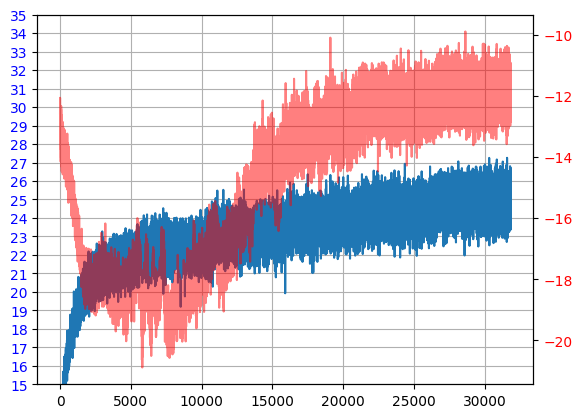

In [6]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
fig, ax1 = plt.subplots()
ax1.plot(-10*np.array(losses)+6.02)
ax1.set_yticks(range(15,36))
ax1.set_ylim([15,35])
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(-10*np.array(rate_losses), color='red', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='red')
plt.show()

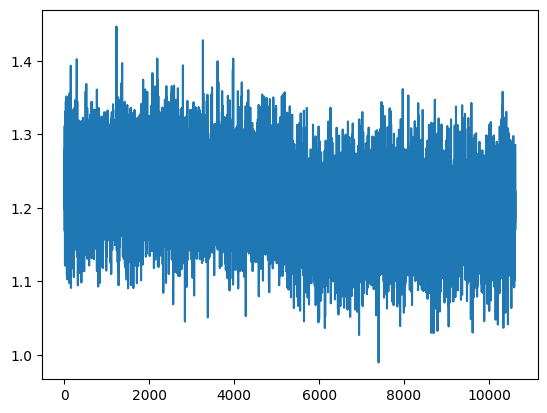

In [22]:
plt.plot(rate_losses[21244:])

In [7]:
# torch.save({
#     'config': config,
#     'state_dict': model.state_dict()
# }, '../hf/dance/LF_rgb_f16c12_v1.8_wtf.pth')

4.708 KB
146.81393372982157x compression ratio
64.0x dimension reduction
22.77838828086853 dB PSNR


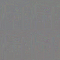

In [23]:
model.eval()
config.img_size=480
img = CenterCrop(config.img_size)(dataset['validation'][28]['image'])
x = PILToTensor()(img).to(device).unsqueeze(0).to(torch.float) / 127.5 - 1.0
x_orig = x[0]
orig_dim = x.numel()

if True:
    model.eval()
    with torch.no_grad():
        z = model.encode(x)
        latent = model.quantize.compand(z).round()
    webp = latent_to_pil(latent.cpu(),n_bits=8, C=3)
    buff = io.BytesIO()
    webp[0].save(buff, format='WEBP', lossless=True)
    size_bytes = len(buff.getbuffer())
    print(f"{size_bytes/1e3} KB")
    print(f"{orig_dim/size_bytes}x compression ratio")
    print(f"{orig_dim/latent.numel()}x dimension reduction")
    latent_decoded = pil_to_latent(webp, N=config.latent_dim, n_bits=8, C=3).to(device)
else:
    model.train()
    with torch.no_grad():
        z = model.encode(x)
        latent_decoded = model.quantize(z)

with torch.no_grad():
    x_hat = model.decode(latent_decoded)
    x_hat = x_hat.clamp(-1,1)
mse = torch.nn.functional.mse_loss(x,x_hat)
PSNR = -10*mse.log10().item() + 6.02
print(f"{PSNR} dB PSNR")
display(webp[0])
# ToPILImage()(x_hat[0]/2+0.5)

bpc: 3.3939570446128533, cr: 150.85635830679865


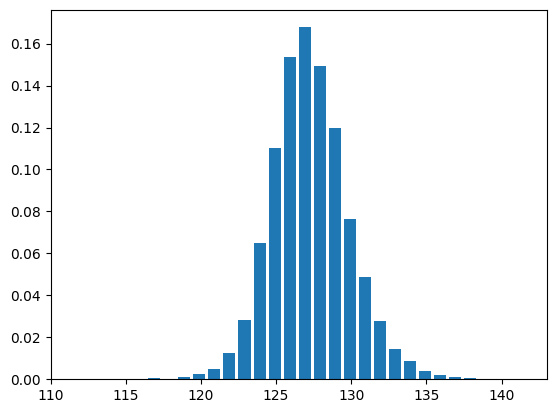

In [24]:
from torch.distributions import Categorical
x_int8 = torch.tensor(np.array(webp[0]))
h = plt.hist(x_int8.flatten(),range=(-0.5,255.5),bins=256,width=0.8,density=True)
bpc = np.log2(np.exp(1))*Categorical(torch.tensor(h[0])).entropy()
plt.xlim([110,143])
print(f"bpc: {bpc.item()}, cr: {orig_dim/latent.numel()*(8/bpc.item())}")

In [25]:
1/(np.mean(rate_losses[-100:])/np.mean(losses[-100:]))

-1.567650267548719